In [ ]:
from os import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Bionic AI/')
from functions import *
import pickle

In [ ]:
subjects_test, events_test = getSubjectsData(test=True)

In [ ]:
subjects, events =  getSubjectsData(test=False)

## Predict for This Trial

In [ ]:
CNN = CNN().double()

In [ ]:
CNN.load_state_dict(torch.load(f"/content/drive/My Drive/Colab Notebooks/Bionic AI/Scenario 3 Models/CNN/Subject1_Model"))

<All keys matched successfully>

In [ ]:
CNN.eval()

p = []
tru = []

x_test, y_test = getBatch(subjects_test[0], events_test[0], 2000, test=False, test1Trial=True)
x_test = (x_test)

preds = CNN(x_test)

p.append(np.array(preds.data))
tru.append(np.array(y_test.data))

preds = p[0]
for i in p[1:]:
    preds = np.vstack((preds,i))
  
test = tru[0]
for i in tru[1:]:
    test = np.vstack((test,i))

## Visualizing Predicted and True Events for a Single Trial

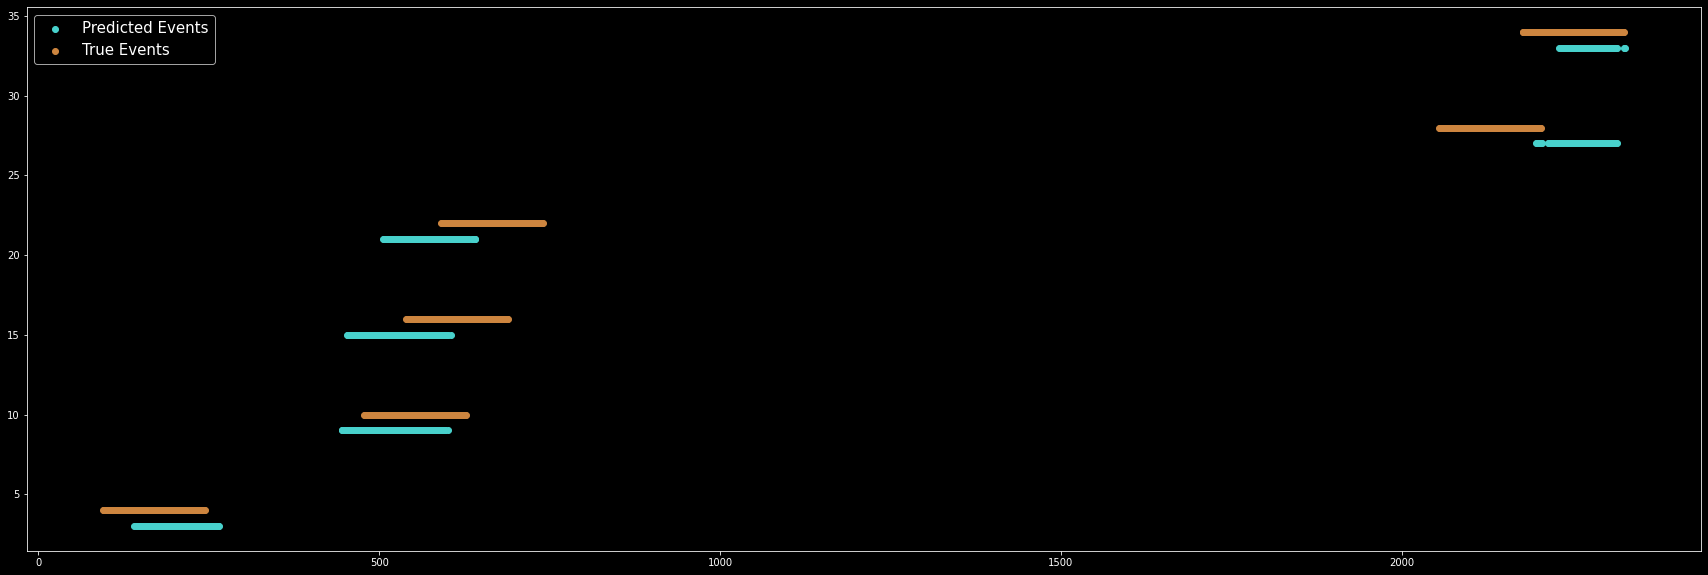

In [ ]:
threshold = getBestThresh(preds,test)

events = [0,1,2,3,4,5]
eventNums = {0: 'HandStart', 1:'FirstDigitTouch', 2:'BothStartLoadPhase', 3:'LiftOff', 4:'Replace', 5:'BothReleased'}
plt.style.use('dark_background')
fig = plt.figure(figsize= [30,10])
ax = fig.add_subplot(1,1,1)

count = 0
for i in range(len(events)):  
  truMotion = np.where(test[:,events[i]] == 1)
  predMotion = np.where(preds[:,events[i]] > threshold[i])
  count += 2

  ax.scatter(predMotion[0], np.ones(len(predMotion[0]))+count,color='mediumturquoise',label='Predicted Events')
  count += 2
  ax.scatter(truMotion[0], np.zeros(len(truMotion[0]))+count, color  = 'peru', label='True Events')
  count += 2
handles,labels = ax.get_legend_handles_labels()
ax.legend(labels[:2], fontsize=15)

# **Animation Demo**

## Prepare the EEG Subplot:  Smoothing Electrode Data

In [ ]:
# create animation for subject 1's first trial from their test series (series 3)

firstTrial = subjects_test[0][:2400]

In [ ]:
# smoothing Data
w = 12
k = 16

firstTrialSmooth = firstTrial.rolling(w).mean()
firstTrialSmooth = firstTrialSmooth.iloc[w-1:,:]
firstTrialShort = firstTrialSmooth.iloc[::k,:]

## Check the Smoothed Data 

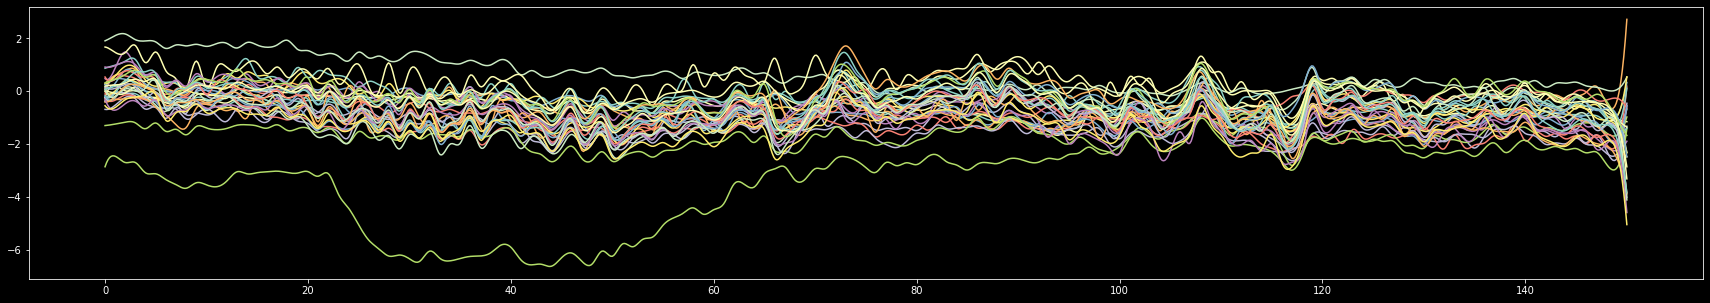

In [ ]:
fig = plt.figure(figsize= [30,5])
    
xnew = np.linspace(0, len(firstTrialShort), 1000) # 300 represents number of points to make between T.min and T.max

spl = make_interp_spline(range(len(firstTrialShort)), firstTrialShort)  # type: BSpline
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth)
plt.show()

## Prepare the Events Subplot: Data Truncating

In [ ]:
testDf = pd.DataFrame(test)
predsDf = pd.DataFrame(preds)

tDf = testDf.iloc[w:,:]
tDf = tDf.iloc[::k,:]

pDf = predsDf.iloc[w:,:]
pDf = pDf.iloc[::k,:]

## Create a Static Graph for Animation

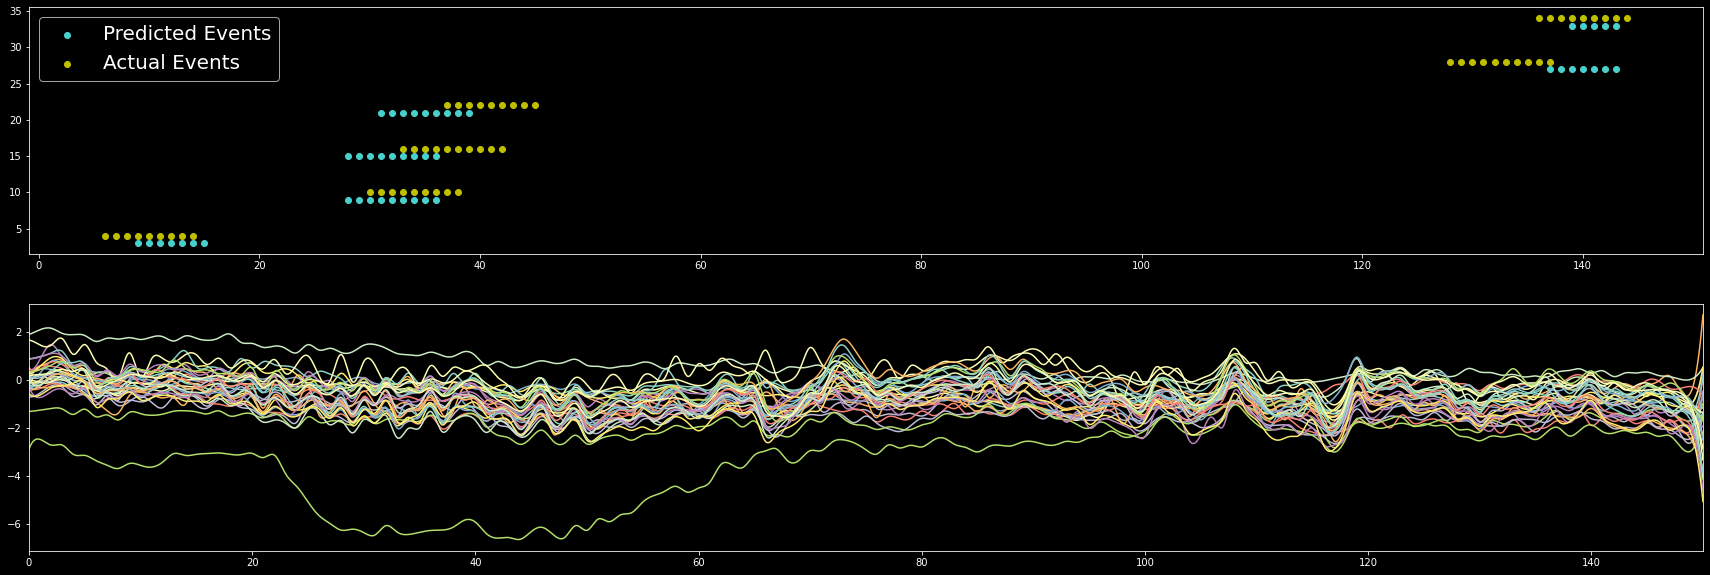

In [ ]:
threshold = getBestThresh(preds,test)
events = [0,1,2,3,4,5]
eventNums = {0: 'HandStart', 1:'FirstDigitTouch', 2:'BothStartLoadPhase', 3:'LiftOff', 4:'Replace', 5:'BothReleased'}
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(2,figsize = (30,10))


for col in range(32):
  
  
  xnew = np.linspace(0, len(firstTrialShort), 2000) 

  spl = make_interp_spline(range(len(firstTrialShort)), firstTrialShort.iloc[:,col], k=3)  
  power_smooth = spl(xnew)
  ax2.plot(xnew, power_smooth)
  ax2.set_xlim(0,150)

count = 0
for ev in events:  
  truMotion = np.where(tDf.iloc[:,ev] == 1)[0]
  predMotion = np.where(pDf.iloc[:,ev] > threshold[ev])[0]
  count += 2

  ax1.scatter(predMotion, np.ones(len(predMotion))+count,color='mediumturquoise',label='Predicted Events')
  count += 2
  ax1.scatter(truMotion, np.zeros(len(truMotion))+count, color  = 'y', label='Actual Events')
  count += 2
ax1.legend(['Predicted Events','Actual Events'],loc= 'upper left',fontsize=20)


## Final Animation

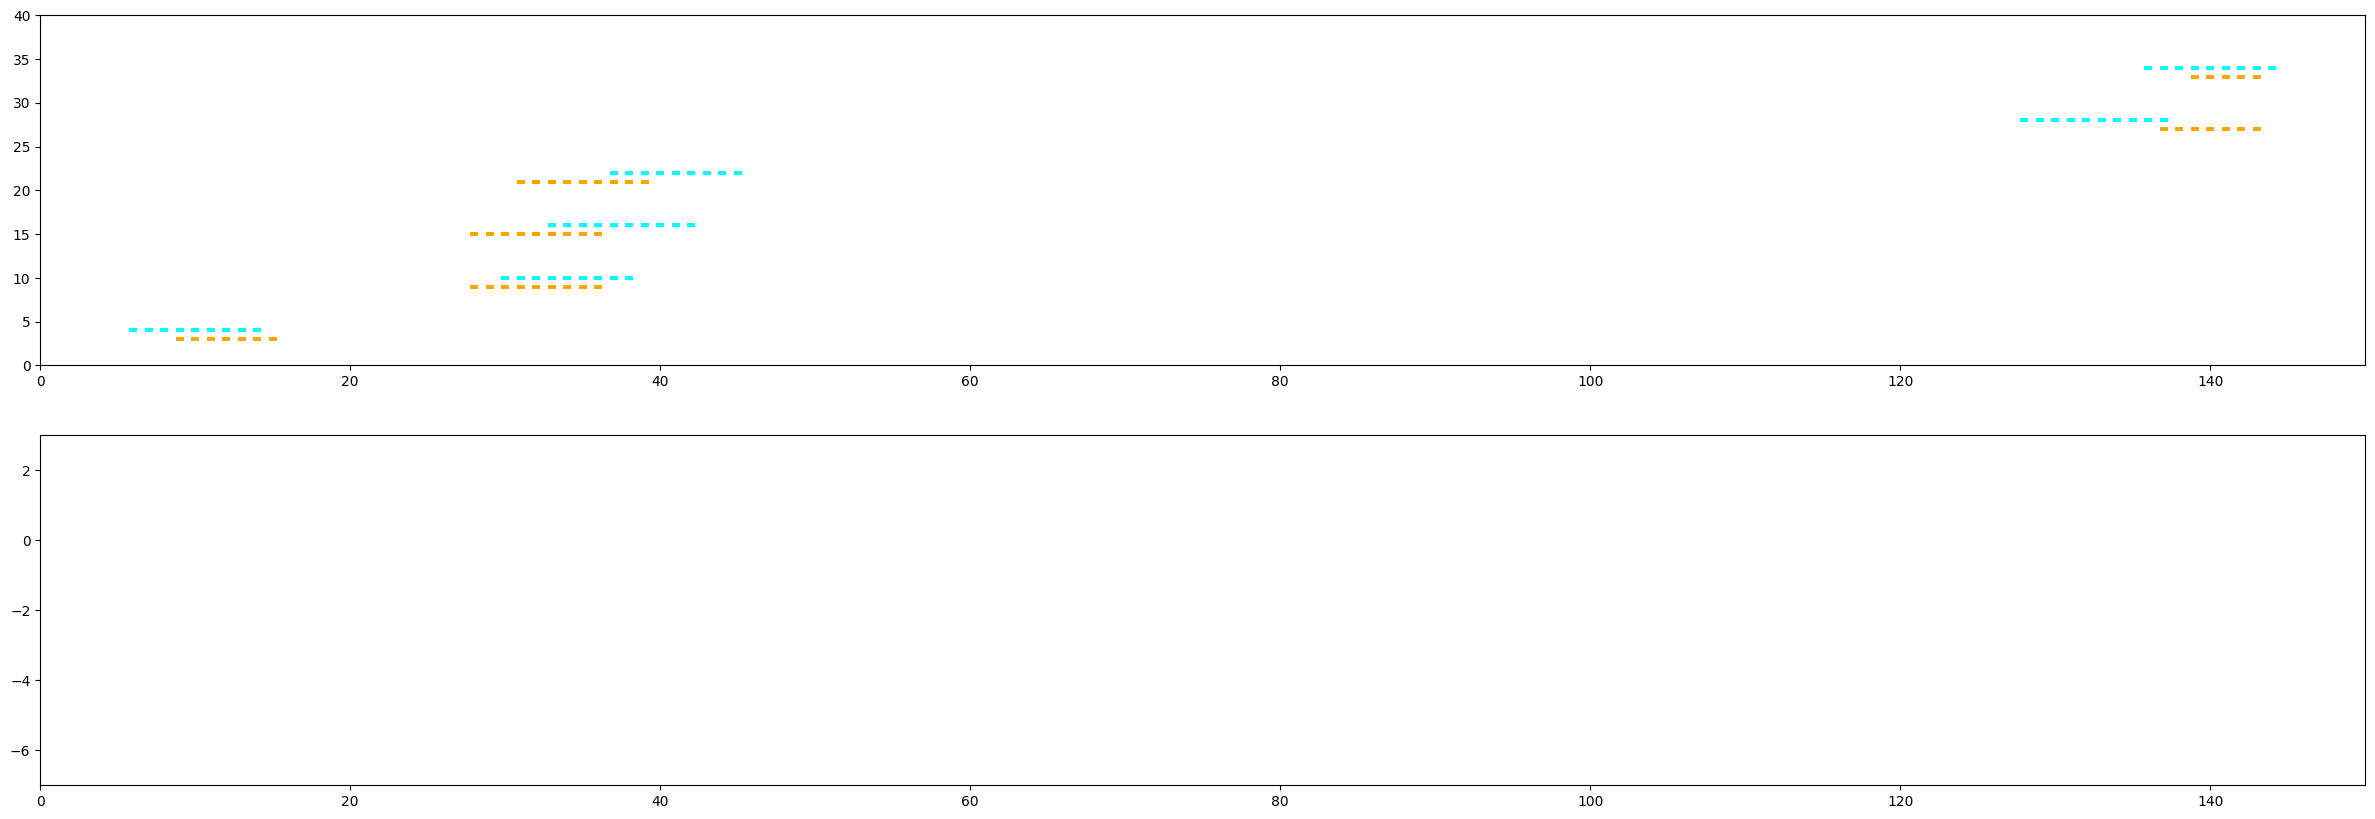

In [ ]:
from matplotlib import animation

threshold = getBestThresh(preds,test)
events = [0,1,2,3,4,5]
eventNums = {0: 'HandStart', 1:'FirstDigitTouch', 2:'BothStartLoadPhase', 3:'LiftOff', 4:'Replace', 5:'BothReleased'}
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(2,figsize = (30,10))

xnew = np.linspace(0, len(firstTrialShort), 1000)

def animate(i):
  plt.cla()
  ax2.set_ylim([-7, 3])
  ax2.set_xlim(0,150)
  ax1.set_ylim(0,40)
  ax1.set_xlim(0,150)

  
  for col in range(32): 

    spl = make_interp_spline(range(len(firstTrialShort)), firstTrialShort.iloc[:,col], k=3)  
    power_smooth = spl(xnew)
    ax2.plot(xnew[:i], power_smooth[:i])
    

  count = 0
  for ev in events:  
    xtru= np.where(tDf.iloc[:,ev] == 1)[0]
    xpred = np.where(pDf.iloc[:,ev] > threshold[ev])[0] 
    count += 2

    ypred = np.ones(len(xpred)) + count
    for j in range(len(xpred)):
      if xnew[i] >= xpred[j]:
        ax1.scatter(xpred[j], ypred[j], color='orange', label='Predicted Events', marker='_',linewidths=150)
    count += 2
    
    ytru = np.zeros(len(xtru)) + count
    for j in range(len(xtru)):
      if xnew[i] >= xtru[j]:
        ax1.scatter(xtru[j], ytru[j], color='cyan', label='True Events', marker='_',linewidths=150)
    count += 2  

anim = animation.FuncAnimation(fig, animate,frames = len(xnew+1), blit = False)
mywriter = animation.FFMpegWriter(fps=40)
anim.save('/content/drive/My Drive/Colab Notebooks/Bionic AI/balck_background_model.mp4', writer=mywriter)